rainbow的代码，只需要把在DQN的基础上，把5个tick添加进来就可。
- double_q的做法，是改进损失函数，防止估计偏高
- priority的做法，是为了改进经验池采样，增进学习速度
- noise_net做法，是为了改进探索，由网络中添加噪声，代替epsilon—greedy策略
- dueling_net做法，是为了改进更新参数的模式，让没有采样的动作的价值函数也能得到更新，改变了网络架构
- distribute_q的做法，是为了改进q网络输出的合理性和真实性，能求出q每个动作的概率分布，进而用每个动作（看成随机变量）的均值当作Q的价值

ranbow单独的改进：
- 对于梯度爆炸问题，需要在step更新模型前一步进行裁剪
  
参考：https://github.com/Curt-Park/rainbow-is-all-you-need

注：segment_tree模块，是从原作者那里copy过来的，不是pip install segment-tree的线段树

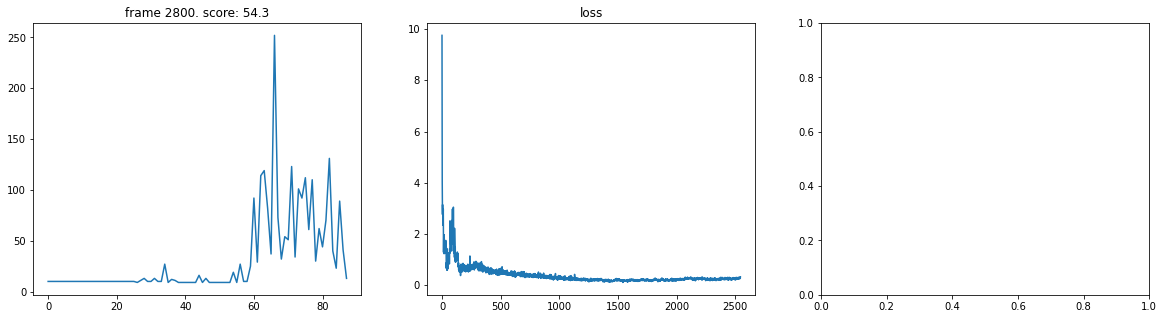

KeyboardInterrupt: 

In [11]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import numpy as np
from typing import Dict,List,Tuple
import math
from segment_tree import MinSegmentTree, SumSegmentTree
from torch.nn.utils import clip_grad_norm_

class ReplayBuffer:
    def __init__(self,obs_dim:int,size:int,batch_size:int =32):
        self.obs_buf = np.zeros([size,obs_dim],dtype=np.float32)
        self.next_obs_buf = np.zeros([size,obs_dim],dtype = np.float32)
        self.acts_buf = np.zeros([size],dtype=np.float32)
        self.rews_buf = np.zeros([size],dtype = np.float32)
        self.done_buf = np.zeros(size,dtype = np.float32)
        self.maxsize,self.batch_size = size,batch_size
        self.ptr,self.size = 0,0
    def store(
            self,
            obs:np.ndarray,
            act:np.ndarray,
            rew:float,
            next_obs:np.ndarray,
            done:bool
    ):
        self.obs_buf[self.ptr]=obs
        self.next_obs_buf[self.ptr]=next_obs
        self.acts_buf[self.ptr]=act
        self.rews_buf[self.ptr]=rew
        self.done_buf[self.ptr]=done
        self.ptr = (self.ptr+1)%self.maxsize
        self.size = min(self.size+1,self.maxsize)
    def sample_batch(self) -> Dict[str,np.ndarray]:
        idxs = np.random.choice(self.size,self.batch_size,replace=False)
        return dict(
            obs = self.obs_buf[idxs],
            next_obs = self.next_obs_buf[idxs],
            acts = self.acts_buf[idxs],
            rews = self.rews_buf[idxs],
            done = self.done_buf[idxs]
            )
    def __len__(self) ->int:
        return self.size
    
#优先级继承
class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self,obs_dim,size,batch_size = 32,alpha = 0.6):
        assert alpha >= 0
        super(PrioritizedReplayBuffer,self).__init__(obs_dim,size,batch_size) #调用父类的构造函数
        self.alpha = alpha
        self.max_priority = 1.0
        self.tree_ptr = 0

        tree_capacity = 1
        while tree_capacity < self.maxsize:
            tree_capacity *=2
        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
    
    def store(
            self,
            obs:np.ndarray,
            act:int,
            rew:float,
            next_obs:np.ndarray,
            done:bool
    ):
        super().store(obs,act,rew,next_obs,done)
        self.sum_tree[self.tree_ptr] = self.max_priority**self.alpha
        self.min_tree[self.tree_ptr] = self.max_priority**self.alpha
        self.tree_ptr = (self.tree_ptr+1)%self.maxsize

    def sample_batch(self,beta = 0.4) -> Dict[str,np.ndarray]:
        assert beta >0
        assert len(self) >= self.batch_size

        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i,beta) for i in indices])

        return dict(obs = obs,
                    next_obs = next_obs,
                    acts = acts,
                    rews = rews,
                    done = done,
                    weights = weights,
                    indices = indices
                    )
    def update_priorities(self,indices:List[int],priorities:np.ndarray):
        assert len(indices) == len(priorities)
        for idx,priority in zip(indices,priorities):
            assert priority > 0
            assert 0 <= idx < len(self)
            self.sum_tree[idx] = priority**self.alpha
            self.min_tree[idx] = priority**self.alpha
            self.max_priority = max(self.max_priority,priority)
    
    def _sample_proportional(self) -> List[int]:
        indices = []
        p_total = self.sum_tree.sum(0,len(self)-1)
        segment = p_total/self.batch_size

        for i in range(self.batch_size):
            a = segment*i
            b = segment*(i+1)
            upperbound = np.random.uniform(a,b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
        return indices
    
    def _calculate_weight(self,idx,beta:float):
        """
        由于采用加重了一部分数据采样的概率，因此在损失函数中，需要降低这些函数的权重，否则会导致bias
        计算权重,其实这个权重的计算公式和论文中的不一样，论文中的是w_i = (N*P(i))**(-beta),这里的是w_i = (p_min*N)**(-beta)
        论文中的是平均采样的概率，这里的是最小采样的概率，影响的是bias的程度，影响不大
        """
        pin_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (pin_min*len(self)) ** (-beta)

        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample*len(self))** (-beta)
        weight = weight / max_weight
        return weight
    
class NoisyLinear(nn.Module):
    def __init__(self,in_features,out_features,std_init = 0.5):
        super(NoisyLinear,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features,in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features,in_features))
        self.register_buffer("weight_epsilon",torch.Tensor(out_features,in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon",torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()
    def reset_parameters(self):
        mu_range = 1/math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range,mu_range)
        self.weight_sigma.data.fill_(self.std_init/math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range,mu_range)
        self.bias_sigma.data.fill_(self.std_init/math.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)
        #copy_()表示将epsilon_in的值复制给weight_epsilon,weight_epsilon是缓冲区，不是参数，不需要求梯度
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return F.linear(x,
                        self.weight_mu+self.weight_sigma*self.weight_epsilon,
                        self.bias_mu +self.bias_sigma*self.bias_epsilon
                        )
    @staticmethod
    def scale_noise(size:int) ->torch.Tensor:
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())


class Network(nn.Module):
    def __init__(self,in_dim,out_dim,atom_size,support:torch.Tensor):
        super(Network,self).__init__()
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        self.feature = nn.Linear(in_dim,128)
        self.advance_noisy_hidden_layer = NoisyLinear(128,128)
        self.value_noisy_hidden_layer = NoisyLinear(128,128)
        self.advance_noisy_out_layer = NoisyLinear(128,out_dim*atom_size)
        self.value_noisy_out_layer = NoisyLinear(128,1)
        
    def forward(self,x:torch.Tensor) ->torch.Tensor:
        #先提取共同特征，然后分别计算Q(s,a)和V(s)
        feature = F.relu(self.feature(x))

        hidden = F.relu(self.advance_noisy_hidden_layer(feature))  
        advance = self.advance_noisy_out_layer(hidden)

        value_hidden = F.relu(self.value_noisy_hidden_layer(feature))
        value = self.value_noisy_out_layer(value_hidden)

        #对advance求分布
        advance = self.dist(advance)
        advance = torch.sum(advance*self.support,dim=2) #求均值，dist是概率分布，self.support是值，相乘后，再按照最后一维求和，得到q值，维度是[batch_size,out_dim]
        
        out = value + advance - advance.mean(dim=-1,keepdim=True)
        return out
    def reset_noise(self):
        self.advance_noisy_hidden_layer.reset_noise()
        self.advance_noisy_out_layer.reset_noise()
        #别忘了新的网络也要reset_noise
        self.value_noisy_hidden_layer.reset_noise()
        self.value_noisy_out_layer.reset_noise()

    def dist(self,x:torch.Tensor) ->torch.Tensor:
        q_atoms = x.view(-1,self.out_dim,self.atom_size) #一个批次的数据，输出维度是[batch_size,out_dim，atom_size]
        dist = F.softmax(q_atoms,dim=-1) #对最后一维进行softmax，保证每一行的和为1
        dist = dist.clamp(min=1e-3)  #将dist限制在[1e-3,1]之间
        return dist
    


class DQN:
    def __init__(
               self,
               env:gym.Env,
               memory_size:int,
               batch_size:int,
               target_update:int,
               #epsilon_decay:float,
               seed:int,
               #max_epsilon:float =1.0,
               #min_epsilon:float =0.1,
               gamma:float = 0.99,

               #Priority_change_begin
               alpha:float = 0.2,
               beta:float = 0.6,
               prior_eps:float = 1e-6,

               v_min:float = 0.0,
               v_max:float = 200.0,
               atom_size:int = 51
     ):
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.n
        self.env = env
        self.memory = PrioritizedReplayBuffer(obs_dim,memory_size,batch_size,alpha)
        self.beta = beta
        self.prior_eps = prior_eps
        self.batch_size = batch_size
        self.target_update = target_update
        #self.epsilon_decay = epsilon_decay
        self.seed = seed
        #self.epsilon = max_epsilon
        #self.min_epsilon = min_epsilon
        self.gamma = gamma
        #self.max_epsilon = max_epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(self.v_min,self.v_max,self.atom_size).to(self.device)

        self.dqn = Network(obs_dim,act_dim,atom_size,self.support).to(self.device)
        self.dqn_target = Network(obs_dim,act_dim,atom_size,self.support).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()                                      # target network is not trainable

        self.optimizer = optim.Adam(self.dqn.parameters(),lr = 1e-3)  #学习率需要调整
        self.transition = list()
        self.is_test = False

       
        
    
    def select_action(self,state:np.ndarray) ->np.ndarray:
         
         
        selected_action = self.dqn(torch.FloatTensor(state).to(self.device)).argmax() 
             #argmax()默认方法keepdim=False，因此相当于argmax(self.dqn(torch.FloatTensor(state)),dim=0,keepdim=False),返回值是零维张量
             #若 argmax(dim=0,keepdim=True)返回值是一维张量
        selected_action = selected_action.detach().cpu().numpy()    #将tensor转化为numpy,并且去掉梯度信息
        if not self.is_test:
             self.transition = [state,selected_action]          #将state和action存储起来,等待下一步的reward和next_state
        return selected_action
     
    def step(self,action:np.ndarray) -> Tuple[np.ndarray,np.float64,bool]:
        next_state,reward,terminated,truncated,_ = self.env.step(action)
        done = terminated or truncated                             #done表示是否结束,
        if not self.is_test:
            self.transition += [reward,next_state,done]            #将reward和next_state,done存储起来
            self.memory.store(*self.transition)                    #将transition存储到memory中
        return next_state,reward,done
    def update_model(self) -> torch.Tensor:

        #改变部分
        samples = self.memory.sample_batch(beta=self.beta)
        weights = torch.FloatTensor(samples["weights"].reshape(-1,1)).to(self.device)
        indices = samples["indices"]
        elementwise_loss = self._compute_dqn_loss(samples)
        loss = torch.mean(elementwise_loss*weights) 
        #其实求均值/求和，然后再方向传播 和 对一个loss列向量（张量）直接反向传播是一样的，因为计算图。。。
        # loss = F.smooth_l1_loss(curr_q_value,target,reduction="none"),reduction表示对loss求和/求均值，none表示返回列向量
        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        loss_for_prior = elementwise_loss.detach().cpu().numpy()  #单个transition的loss就是δ，δ = |Q(s_t,a_t)-[r_t+γ*max_aQ(s_t+1,a)]|
        new_priorities = loss_for_prior + self.prior_eps        #软化因子，防止除零情况
        self.memory.update_priorities(indices,new_priorities)
        
        #改变部分结束

      
        #reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()  #.item()表示返回tensor中的元素值,不是tensor本身，不是tensor类型，所以不能反向传播
    def _compute_dqn_loss(self,samples:Dict[str,np.ndarray]) -> torch.Tensor:
        device = self.device
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        #下面设个tensor维度重构很重要，因为action,reward,done都是一维的，
        #求curr_q_value时，需要按行取值，使用gather()函数，需要保证action的维度是[batch_size,1]
        #action从行向量转化为列向量，reshape(-1,1)
        action = torch.LongTensor(samples["acts"]).to(device).reshape(-1,1)
        reward = torch.FloatTensor(samples["rews"]).to(device).reshape(-1,1)
        done = torch.FloatTensor(samples["done"]).to(device).reshape(-1,1)

        #计算Q(s_t,a_t),
        #网络的输出层维度是action数目
        #每次计算loss，都是一个批次的数据计算，在这里假设是cartpole，action数目为2，所以输出层维度为2
        #self.dqn(state).shape = [batch_size,2],action.shape = [batch_size,1],按照gather，表示取每一行的action对应的值
        #因此，curr_q_value.shape = [batch_size,1]
        curr_q_value = self.dqn(state).gather(1,action)  #gather(1,action)表示按行取action对应的值
        #计算Q(s_t+1,a_t+1)
        chosen_action = self.dqn(next_state).argmax(dim=1,keepdim = True)
        next_q_value = self.dqn_target(next_state).gather(1,chosen_action).detach()
        #next_q_value = self.dqn_target(next_state).max(dim=1,keepdim=True)[0].detach() #dim=1表示按行取最大值,[0]表示取值,[1]表示取索引
        
        mask = 1-done
        target = (reward+self.gamma*next_q_value*mask).to(self.device)

        #loss的维度是[batch_size,1]，reduction="none"表示不对loss求和/求均值，返回列向量
        loss = F.smooth_l1_loss(curr_q_value,target,reduction="none")

        return loss
    def train(self,num_frames,plotting_interval=200):
        self.is_test = False
        state,_ = self.env.reset(seed=self.seed)
        update_cnt = 0
        #epsilons = []
        losses = []
        scores = []
        score = 0

        
        
        for frame_idx in range(1,num_frames+1):
            action = self.select_action(state)
            next_state,reward,done = self.step(action)
            state = next_state
            score += reward

            #逐步增大beta
            fraction = min(frame_idx/num_frames,1.0)
            self.beta = self.beta + fraction*(1.0-self.beta)
            
            if done:
                state,_ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0
            if len(self.memory) > self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                #self.epsilon = max(self.min_epsilon,self.epsilon - (self.max_epsilon-self.min_epsilon)*self.epsilon_decay)
                #epsilons.append(self.epsilon)

                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
            
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx,scores,losses)
        
        self.env.close()
        print(scores)

    def _target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())
    def _plot(self,frame_idx,scores,losses):
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.show()

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic =True
        torch.backends.cudnn.benchmark = False
#主函数
if __name__ == "__main__":
    env = gym.make("CartPole-v1",max_episode_steps=500,render_mode = "rgb_array")

    seed = 777
    np.random.seed(seed)
    seed_torch(seed)

    #设置参数
    num_frames = 10000
    memory_size = 1000
    batch_size = 256
    target_update = 100
    

    agent = DQN(env=env,memory_size=memory_size,batch_size=batch_size,target_update=target_update,seed=seed)
    agent.train(num_frames)

